### Introduction: This is the Jupyter notebook to do the flowing things:

1. Read the `FitShapes.root` files produced by `CombineTools`, and plot the `pre-fit` and `post-fit` shapes, unc added.

env:HWW


### Import necessary modules

In [1]:
import numpy as np
import os
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from scipy import interpolate
import uproot  # means uproot4
from hist.intervals import ratio_uncertainty

print('Python', os.sys.version)
print('uproot', uproot.version.version)

Python 3.8.14 (default, Apr  2 2023, 16:25:05) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-44)]
uproot 4.3.7


In [2]:
YEAR = "2018"
FIT = "prefit"

### Define templates dir

In [3]:
MAIN_DIR = "./plots"

plot_dir = f"{MAIN_DIR}/fitshapes/15Jul2024_{FIT}"
os.makedirs(plot_dir, exist_ok=True)

### Define combine datacards path

In [4]:
cards_dir = f"../combine/cards/{YEAR}/"

### plot setting

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=True):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])


# function to find the optimal region with S/sqrt(B)
# not used so far
def optimalcut(shist, bhist):
    n_bins = len(shist)
    best_lower = None
    best_upper = None
    best_s_sqrt_b = 0

    for lower in range(n_bins):
        for upper in range(lower+1, n_bins+1):
            s = np.sum(shist[lower:upper])
            b = np.sum(bhist[lower:upper])
            s_sqrt_b = s / np.sqrt(b + 1)

            if s_sqrt_b > best_s_sqrt_b:
                best_lower = lower
                best_upper = upper
                best_s_sqrt_b = s_sqrt_b

    return best_lower, best_upper, best_s_sqrt_b

def optimalcut_oneside(shist, bhist, epsilon = 0.01):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist)
    best_cut = 0
    best_s_sqrt_b = 0

    for cut in range(n_bins):
        s = np.sum(shist[cut:])
        b = np.sum(bhist[cut:])
        s_sqrt_b = s / np.sqrt(b + epsilon)
        if s_sqrt_b > best_s_sqrt_b:
            best_cut = cut
            best_s_sqrt_b = s_sqrt_b
        
    return best_cut, best_s_sqrt_b

def optimalcut_mid_combine(shist1, shist2, bhist, epsilon = 1):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist1)
    best_cut = 0
    best_combined_sig_two_side = 0

    for cut in range(n_bins):
        s_right_side = np.sum(shist2[cut:])
        b_right_side = np.sum(bhist[cut:])
        s_left_side = np.sum(shist1[:cut])
        b_left_side = np.sum(bhist[:cut])
        s_sqrt_b_right_side = s_right_side / np.sqrt(b_right_side + epsilon)
        s_sqrt_b_left_side = s_left_side / np.sqrt(b_left_side + epsilon)
        combined_sig_two_side = np.sqrt((s_sqrt_b_right_side)**2 + (s_sqrt_b_left_side)**2)
        if combined_sig_two_side > best_combined_sig_two_side:
            best_cut = cut
            best_combined_sig_two_side = combined_sig_two_side
        
    return best_cut, best_combined_sig_two_side

### define functions read FitShape.root files

In [6]:
def read_root(filename = "./FitShapes.root", region = "SR2a_postfit", process = "ggF"):
    ''' 
    filename:path/to/root
    dir:"QCD"
    name:region from ["CR1",...]
    '''
    with uproot.open(filename) as file:
        hist = file.get(region + "/" + process)
        h = np.array(hist.values())
        var = np.array(hist.variances())        
    return h, var
    # here we defined a simple function to read the predicted QCD,etc. shapes from root file directly
    # but you have to be sure with the accuracy about the root file

### read the FitShapes.root files

In [7]:
#dict about process names and the names in the root files
def load_fitshapes(cards_dir = cards_dir, region = "SR1a", reg_str = "_postfit"):
    name_dict_data = {
        #data
        "data": "data_obs",
    }
    name_dict_bkg = {
        #bkg
        "QCD"  :"CMS_Wcb_boosted_qcd_datadriven",
        "Top"  :"top",
        "WJets":"wjets",
        "Rest" :"rest_bkg",
        #Total bkg
        "TotalBkg":"TotalBkg",
    }
    name_dict_sig = {
        #sig
        "Signal":"TotalSig",
    }
    name_dict = {**name_dict_bkg , **name_dict_sig , **name_dict_data}
    files_value = {process : {} for process in name_dict}
    files_var   = {process : {} for process in name_dict}
    # regions = ["SR1a","SR1b","CR1","SR2a","SR2b","CR2"]
    # for region in regions:
    name_dict_tmp = {**name_dict_bkg , **name_dict_data} if region.startswith("CR") else name_dict
    for process in name_dict_tmp:
        print("NOW",process)
        files_value[process],files_var[process] = read_root(filename = f"{cards_dir}/FitShapes.root",region = region + reg_str, process = name_dict_tmp[process])
        # print("done",region, process)
    if region.startswith("CR"):
        for process_tmp in name_dict_sig :
            #random samples to extract the bins info
            value_eg, var_eg = read_root(filename = f"{cards_dir}/FitShapes.root",region = "SR1" + reg_str, process = "ttbar")
            files_value[process_tmp],files_var[process_tmp] = np.zeros_like(value_eg),np.zeros_like(var_eg)
            # print("done",region, process_tmp)
    return files_value,files_var

### Plot variables

In [8]:
from matplotlib.cm import get_cmap
hep.style.use("CMS")
def fitshapes_plot(arrays,arrays_var, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False,log = False,blind = True, blindMC = False, nametext = "",optimal_cut = True, deco = False,postfit_files = ""):
    LUMI = {"2016APV": 19.52, "2016": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/bins
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()    
    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["QCD","Top","WJets","Rest"]
    name_dict_sig = {
        #sig
        "Signal":"TotalSig",
    }
    for (k,v) in arrays.items():
        # print(k)
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        # hist.fill(values)
        # h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        h = arrays[k]
        var = arrays_var[k]
        # here the var are just usual standard variance
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        elif k in name_dict_sig or k == "data":
            individual['h'][k] = h
            individual['var'][k] = var        
    #plot
    SIG_COLOR={'Signal': 'black'}
    SIG_DECO_COLOR = {'Signal': 'black'}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    if len(stacked['h'].keys())>0:
        BKG_list = ["Rest","WJets","Top","QCD"]
        # err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        # colors = ["#1f77b4", "#ff7f0e", "#2ca02c","green","#d62728"] #old color regime
        #colors = ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1"] #latest color regime according to:https://cms-analysis.docs.cern.ch/guidelines/plotting/colors/#1d-histogramstackplot
        ## corresponds to Rest, WJets, TT, ST, QCD
        colors = ["#5790fc", "#f89c20", "#e42536", "#9c9ca1"] #latest color regime according to:https://cms-analysis.docs.cern.ch/guidelines/plotting/colors/#1d-histogramstackplot
        # corresponds to Rest, WJets, Top, QCD
        # colors = colors[::-1]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list,  histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        # bkg_err = np.sum(err_list ,  axis=0)
        bkg_err = np.sqrt(arrays_var["TotalBkg"]) #directly from fitshapes.root
        # print("err",bkg_err)
        bin_edges = np.linspace(x_min, x_max, bins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        
        #plot grey bar for systematic uncertainties
        # ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
        
        #add dashed region for systematic uncertainties
        errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 0,
            "alpha": 0.4,
            "label":"Syst. Unc.",
        }
        ax.stairs(values = bkg_h + bkg_err, baseline = bkg_h - bkg_err, edges = hist.axes[0].edges, **errps)
        
    # Scale the signal according to total BKG to make it visiable:
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["Signal"])+0.000001)
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    for (k,h) in individual['h'].items():
        if k=='data': #data
            
            err_data = error_bar(h, individual['var'][k], type='data')
            # err_data = np.sqrt(arrays_var["data"])
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err_data, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            

            err_bkg = np.sqrt(arrays_var["TotalBkg"])
            h_bkg = arrays["TotalBkg"]
            
            data_mc_ratio = np.sum(h)/np.sum(bkg_h)
            
            # error:
            
            # old implementation: plot ratio error with MC and data error together:
            # ratio_error = (h/h_bkg)*np.sqrt(np.power(err_data/h,2) + np.power(err_bkg/h_bkg,2))
            # hep.histplot(h/h_bkg, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)    
            
            # now first directly scale the data error with `data/MC` ratio
            hep.histplot(h/h_bkg, bins=hist.axes[0].edges, yerr=ratio_uncertainty(h,h_bkg,"poisson"), color='black', histtype='errorbar', density=density, stack=False, ax=ax1)    
            
            # then add shaded error to ratio plot
            errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 1,
            "alpha": 0.4,
            "label":"Syst. Unc."
            }
            
            ax1.stairs(values = 1 + err_bkg/h_bkg, baseline = 1 - err_bkg/h_bkg, edges = hist.axes[0].edges, **errps)
        
        else:  # signal
            # print("sig",k)
            if h[1] == 0 : 
                print(k,"is 0")
                optimal_cut == False
                continue 
                #control region doesn't have signal yields
            if deco != True:
                if k in ["Signal"]:
                    # err = error_bar(h, individual['var'][k], type='mc')
                    
                    #directly use the unc from combine output
                    err = np.sqrt(individual['var'][k])
                    hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
                    y = h / np.sqrt(bkg_h + 1)
                    # for signal, just keep the original unc style
                    hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])
                    
            if k == "Signal":
                best_lower, best_upper, best_s_sqrt_b = optimalcut(h,bkg_h)
                print("Optimal two-side cut =",best_lower, best_upper, best_s_sqrt_b)
                best_cut, best_s_sqrt_b = optimalcut_oneside(h,bkg_h)
                print("Optimal one-side cut =",best_cut, best_s_sqrt_b) 
                # best_cut, best_combined_sig_two_side = optimalcut_mid_combine(individual['h'][r"$H^{4q}$"],individual['h'][r"$H^{lqq}$"],bkg_h)
                # print("Optimal mid-side cut = ",best_cut,best_combined_sig_two_side)
            if optimal_cut == True:
                cut_value_low = x_min + best_lower * (x_max - x_min)/bins
                ax2.axvline(x=cut_value_low, color='r', linestyle='-')
                ax2.annotate('', xy=(cut_value_low, ax2.get_ylim()[1]), xytext=(cut_value_low - (x_max - x_min)/20 , ax2.get_ylim()[1]),arrowprops=dict(facecolor='red', arrowstyle="->"))                
                cut_value_up = x_min + best_upper * (x_max - x_min)/bins
                ax2.axvline(x=cut_value_up, color='r', linestyle='-')
                ax2.annotate('', xy=(cut_value_up, ax2.get_ylim()[1]), xytext=(cut_value_up + (x_max - x_min)/20 , ax2.get_ylim()[1]),arrowprops=dict(facecolor='red', arrowstyle="->"))                
                if cut_value_low < (x_max - cut_value_up):
                    text_position = cut_value_up + (x_max - x_min)/20
                    ax2.text(text_position, ax2.get_ylim()[1], r'$S/\sqrt{B+1}$'+"=%s"%(str(round(best_s_sqrt_b,3))), verticalalignment='center', horizontalalignment='left',fontsize = 13)
                else: 
                    text_position = cut_value_low - (x_max - x_min)/20
                    ax2.text(text_position, ax2.get_ylim()[1], r'$S/\sqrt{B+1}$'+"=%s"%(str(round(best_s_sqrt_b,3))), verticalalignment='center', horizontalalignment='right',fontsize = 13)

    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_yscale('log')
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1e1)
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)
    # if not density:
    #     ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        # ax1.set_ylim(0, 2)
        ax1.set_ylim(0.3, 1.8)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.4)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    if blind:
        plt.text(0.05,0.83,region ,fontsize=17, color="black", ha='left',transform=ax.transAxes)
        plt.text(0.05,0.76,othertext,fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,region,fontsize=17, color="black", ha='left',transform=ax.transAxes)
        plt.text(0.05,0.73,othertext,fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=12)
    suffix = '_AU' if density else ''
    if deco: suffix += "_DECO"
    path_str = plot_dir
    if not os.path.exists(path_str):
        os.makedirs(path_str)
    othertext = othertext.replace(",","")
    othertext = othertext.replace(" ","")
    othertext = othertext.replace("(","")
    othertext = othertext.replace(")","")
    othertext = othertext.replace("=","")
    plt.savefig(f"{path_str}/{year}_{plot_name}{suffix}_{region}{othertext}{nametext}.pdf", bbox_inches='tight')
    plt.show()

In [9]:
def fitshapes_runPlots(region = "PS", reg_str = f"_{FIT}",nametext = "", othertext = "",year=f"{YEAR}"): 
    arrays,arrays_var = load_fitshapes(region = region,reg_str = reg_str)
    fitshapes_plot(arrays,arrays_var,  region = region, nametext = nametext, othertext = othertext,plot_name='MH_Reco', x_name=r'$jet_{a}$: soft-drop mass', x_max=230, x_min=30, bins=20, year=year,deco = False)

### plot order = (3,6) post-fit fitshapes

NOW QCD
NOW Top
NOW WJets
NOW Rest
NOW TotalBkg
NOW Signal
NOW data
Should scale signal *  129.52641412026256
Optimal two-side cut = 3 8 0.6163790135112205
Optimal one-side cut = 3 0.4506429591512767


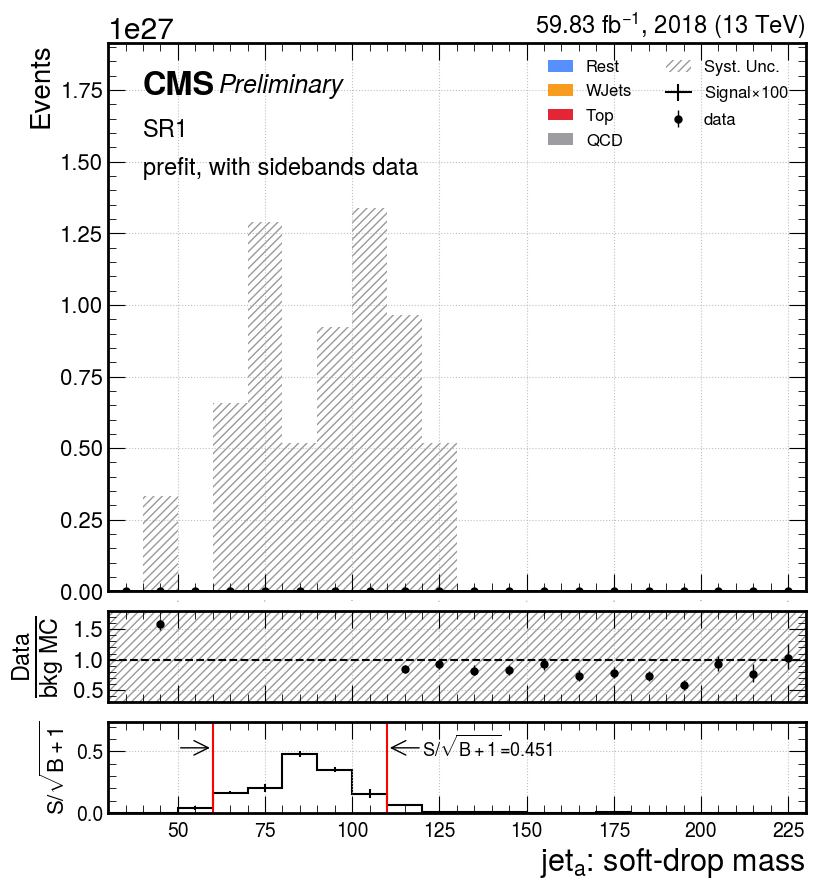

NOW QCD
NOW Top
NOW WJets
NOW Rest
NOW TotalBkg
NOW Signal
NOW data
Should scale signal *  833.739996702361
Optimal two-side cut = 4 8 0.3924562463314389
Optimal one-side cut = 3 0.27980998129475965


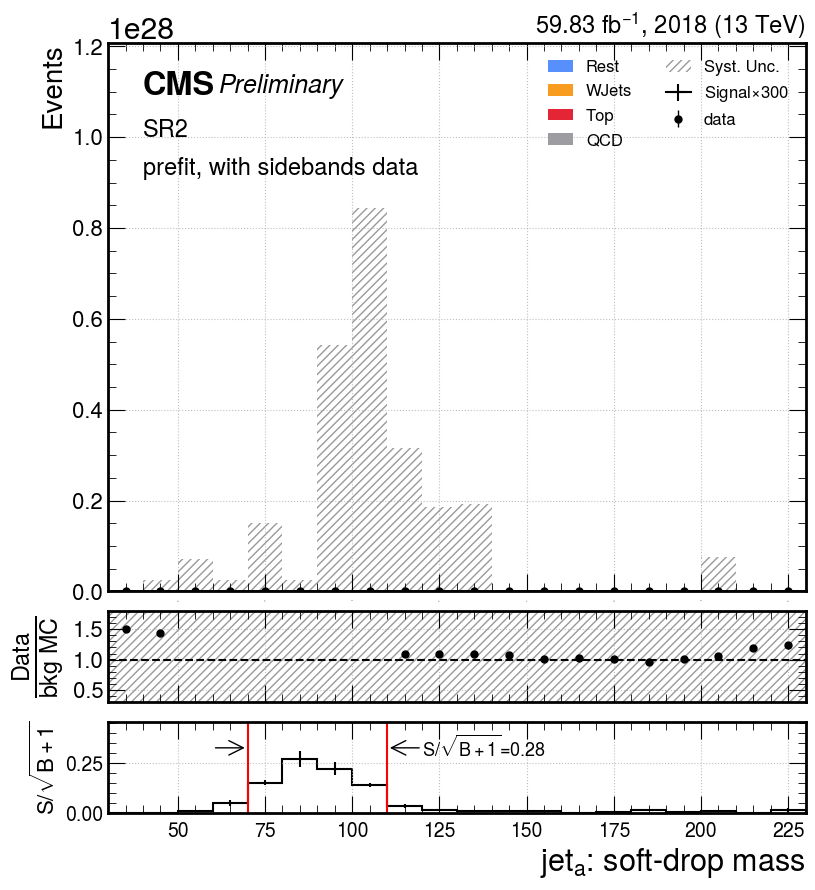

NOW QCD
NOW Top
NOW WJets
NOW Rest
NOW TotalBkg
NOW Signal
NOW data
Should scale signal *  3212.094217767865
Optimal two-side cut = 4 8 0.18790827130039692
Optimal one-side cut = 3 0.15413015229544433


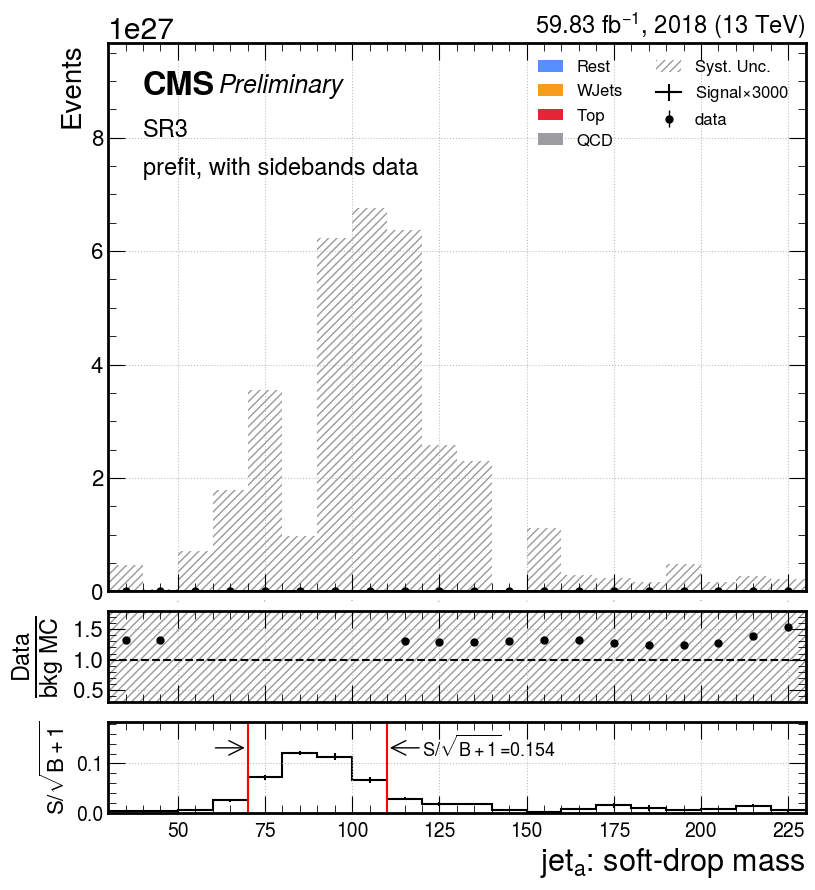

NOW QCD
NOW Top
NOW WJets
NOW Rest
NOW TotalBkg
NOW data


AttributeError: 'NoneType' object has no attribute 'values'

In [10]:
fitshapes_runPlots(region = "SR1", othertext = f"{FIT}, with sidebands data")
fitshapes_runPlots(region = "SR2", othertext = f"{FIT}, with sidebands data")
fitshapes_runPlots(region = "SR3", othertext = f"{FIT}, with sidebands data")
fitshapes_runPlots(region = "CR",  othertext = f"{FIT}, with sidebands data")